In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from time import gmtime, strftime
from TrainValTensorBoard import TrainValTensorBoard

import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


#### 1) Custom DNN regressor with estimator
#### 2) CNN sequential Keras API
#### 3) CNN functional Keras API

# 2) Data Processing

In [3]:
df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')

In [4]:
def preprocess_data(df_train):
    df_train_rand = df_train.reindex(np.random.permutation(df_train.index))
    return df_train_rand

In [5]:
def preprocess_features(x_train):
    #Normalization to greyscale, reduces the effect of illumination's differences
    x_train_norm = x_train / 255
    #Reshaping for keras 28x28x1 3D matrices?
    x_train_norm = x_train_norm.values.reshape(-1, 28, 28, 1)
    return x_train_norm

In [6]:
def preprocess_targets(y_train):
    #Encode labels to one hot vecs
    y_train_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
    return y_train_hot

In [7]:
df_train_rand = preprocess_data(df_train)
X_train = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).head(38000).copy())
X_val = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).tail(6000).copy())
Y_train = preprocess_targets(df_train_rand['label'].head(38000).copy())
Y_val = preprocess_targets(df_train_rand['label'].tail(6000).copy())

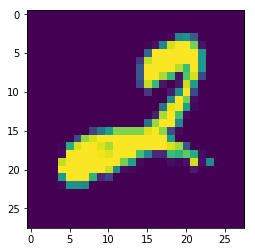

In [8]:
g = plt.imshow(X_train[0][:,:,0])

Filters are transformations of the image.
Filters' size is defined by kernel size


In [9]:
#Architecture:
#[[Conv2D->reulu]*2] -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Softmax
 
model = tf.keras.Sequential()

model.add(layers.Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu',
                 input_shape = (28, 28, 1)))
#The model needs to know what input shape it should expect, the following layer can do automatic shape inference
# by counting the previous layers output shape? yes, we already have that number
# 2D layers such as dense support input_dim instead of input_shape
model.add(layers.Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu'))

model.add(layers.MaxPool2D(pool_size=(2,2),
                   strides=(2,2)))
# it is typical to not have overlap during pooling, I intuit it is in order to reduce noise and duplication

model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same',
                activation = 'relu'))
model.add(layers.Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same',
                activation = 'relu'))

model.add(layers.MaxPool2D(pool_size=(2,2),
                    strides=(2,2)))


model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(245, activation = 'relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# Optimizer, required for compiling a Keras model
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001,
                                   beta1 = 0.9,
                                   beta2 = 0.999,
                                   epsilon = 1e-08,
                                   use_locking = False,
                                  name = 'Adam')

In [11]:
# optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)

In [12]:
# Compiling
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
# Learning rate reduction
# Keras has a list of callback functions which we can use to apply at different stages of training.
# We can pass the as the keyword argument 'callbacks' to the .fit() method of Sequential or Model classes
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, 
# the learning rate is reduced.
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 3,
                                           verbose = 1,
                                           factore = 0.5,
                                           min_lr = 0.00001)

In [20]:
epochs = 5
batch_size = 80

In [21]:
# Data augmentation


In [22]:
tensorboardg = TrainValTensorBoard()

In [23]:
# Fit, returns a History object, its history attribute is a record of training loss values and metrics values at 
# sequential epochs, as well as validation loss values and validation metrics values
history = model.fit(X_train,
                    Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (X_val, Y_val),
                    verbose = 2,
                    callbacks=[TrainValTensorBoard()])

Train on 38000 samples, validate on 6000 samples
Epoch 1/5
 - 98s - loss: 0.0616 - acc: 0.9820 - val_loss: 0.0314 - val_acc: 0.9900
Epoch 2/5
 - 99s - loss: 0.0500 - acc: 0.9853 - val_loss: 0.0252 - val_acc: 0.9917
Epoch 3/5
 - 114s - loss: 0.0442 - acc: 0.9861 - val_loss: 0.0278 - val_acc: 0.9893
Epoch 4/5
 - 107s - loss: 0.0369 - acc: 0.9886 - val_loss: 0.0275 - val_acc: 0.9910
Epoch 5/5
 - 98s - loss: 0.0329 - acc: 0.9894 - val_loss: 0.0210 - val_acc: 0.9933


In [23]:
x_test = preprocess_features(df_test)
x_test.shape

(28000, 28, 28, 1)

In [56]:
predictions = model.predict(x_test)
predictions.shape

(28000, 10)

In [57]:
predictions.shape

(28000, 10)

In [58]:
results = np.argmax(predictions, axis=1)
results = pd.Series(results, name='Label')
results

0        2
1        0
2        9
3        9
4        3
5        7
6        0
7        3
8        0
9        3
10       5
11       7
12       4
13       0
14       4
15       3
16       3
17       1
18       9
19       0
20       9
21       1
22       1
23       5
24       7
25       4
26       2
27       7
28       4
29       7
        ..
27970    5
27971    0
27972    4
27973    8
27974    0
27975    3
27976    6
27977    0
27978    1
27979    9
27980    3
27981    1
27982    1
27983    0
27984    4
27985    5
27986    2
27987    2
27988    9
27989    6
27990    7
27991    6
27992    1
27993    9
27994    7
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [60]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [61]:
submission.to_csv("CNN_sequential_mnist.csv", index=False)